# Main Notebook of Milestone 1 Presentation

In [1]:
__author__ = "Josh Fisher, Nick Bermudez, and Zhou Jiang"

In [2]:
import os
import json

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from collections import namedtuple, Counter

from visualizations import Visualizations, AutoEDAVisualizatons

## Data Source

We were interested in two of the CDC's National Health and Nutrition Examination Survey (NHANES) datasets. Specifically, the demographics dataset [(link)](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Demographics&Cycle=2017-2020) and the total nutrient intakes dataset [(link)](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Dietary&Cycle=2017-2020).

The demographics survery asks questions regarding demographic factors such as pregnancy status, ratio of family income to poverty, and "other selected demographic information, such as gender, age, race/Hispanic origin, education, marital status, country of birth, and years of U.S. residence." [source](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DEMO.htm)

"The objective of the dietary interview component is to obtain detailed dietary intake information from NHANES participants. The dietary intake data are used to estimate the types and amounts of foods and beverages (including all types of water) consumed during the 24-hour period prior to the interview (midnight to midnight), and to estimate intakes of energy, nutrients, and other food components from those foods and beverages." [source](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DR1TOT_I.htm)

We were able to scrape all available years for both datasets but opted to use only the most recent report as we were interested in current health trends. You can check out the webscraping script at [Scripts/webscrape.py](webscrape.py)

The format of each dataset is .xpt and the variable names are encoded. Data is stored in Data/Final/*.xpt and data dictionaries mapping encoded_var: var can be found in same directory. There are a relatively small number of rows where all values we were interested were NaNs so we opted to drop those.

In [3]:
class NHANESDataFrame:
    """ This class is specific to NHANES dataset and contains cleaning functions, utilities, etc. """
    def __init__(self, path):
        self.path = path

    def clean_demographics_df(self):
        """ returns cleaned, renamed, demographics dataframe """
        demo_d = self.get_demographics_dict()
        df = pd.read_sas(self.path)

        # filter, only include cols in demo_d.keys()
        df = df[list(demo_d.keys())]

        # rename to demo_d.valuese()
        df = df.rename(columns=demo_d)

        # Removing rows where all values are NaN
        temp = list(demo_d.values())
        temp.remove('id')
        return df

    def clean_total_nutrients_df(self):
        """ returns cleaned, renamed, total nutrients dataframe """
        d = {'SEQN': 'id'}
        macro_d = self.get_macronutrient_dict()
        ess_d = self.get_essential_vitamins_dict()
        oth_d = self.get_other_nutrients_dict()

        d.update(macro_d)
        d.update(ess_d)
        d.update(oth_d)

        df = pd.read_sas(self.path)

        # filter
        df = df[list(d.keys())]
        # rename
        df = df.rename(columns=d)
        return df

    @staticmethod
    def read_combine_clean_demographics_total_nutrients(demographics_path, total_nutrients_path):
        """ Reads demographics and total nutrients, clean both, and merge the two dataframe together """
        demo_df = NHANESDataFrame(demographics_path).clean_demographics_df()
        nuts_df = NHANESDataFrame(total_nutrients_path).clean_total_nutrients_df()
        df = demo_df.merge(nuts_df, on='id')
        return df

    @staticmethod
    def get_essential_vitamins_dict():
        """
        https://www.nia.nih.gov/health/vitamins-and-supplements/vitamins-and-minerals-older-adults#:~:text=There%20are%2013%20essential%20vitamins,keep%20the%20body%20working%20properly.
        There are 13 essential vitamins —
        vitamins A, C, D, E, K,
        and the B vitamins (thiamine, riboflavin, niacin, pantothenic acid, biotin, B6, B12, and folate).

        no pantothenic acid in NHANES
        no biotin in NHANES

        :return:
            encoded_var: var
        """
        d = {
            "DR1TVARA": 'vitaminA', "DR1TVC": "vitaminC", "DR1TVD": "vitaminD", "DR1TATOC": 'vitaminE', "DR1TVK": "vitaminK",
            "DR1TVB1": 'thiamine', "DR1TVB2": "riboflavin", "DR1TNIAC": 'niacin', "DR1TVB6": "vitaminB6",
            "DR1TVB12": "vitaminB12", "DR1TFOLA": "folate"
        }
        return d

    @staticmethod
    def get_macronutrient_dict() -> dict:
        """
        Common macronutrients
        :return:
            encoded_var: var
        """
        d = {"DR1TKCAL": "kcals", "DR1TPROT": "protein", "DR1TCARB": "carbs", "DR1TSUGR": "sugar",
            "DR1TTFAT": "total_fat", "DR1TSFAT": "sat_fat", "DR1TMFAT": "mono_fat", "DR1TPFAT": "poly_fat",
            "DR1TCHOL": "cholesterol"}
        return d

    @staticmethod
    def get_other_nutrients_dict() -> dict:
        d = {"DR1TCALC": "calcium", "DR1TPHOS": "phosphorus", "DR1TMAGN": "magnesium",
             "DR1TIRON": "iron", "DR1TZINC": "zinc", "DR1TCOPP": "copper", "DR1TSODI": "sodium",
             "DR1TPOTA": "potassium", "DR1TSELE": "selenium", "DR1TCAFF": "caffeine",
             "DR1TTHEO": "theobromine", "DR1TALCO": "alcohol"}
        return d

    @staticmethod
    def get_demographics_dict() -> dict:
        with open('../Data/Final/demographics.json') as f:
            d = json.load(f)
        return d

    @staticmethod
    def get_nhanes_to_fda_rec_dict() -> dict:

        """
        d was gotten using:
            cols = df_nhanes.columns.tolist()
            recs = df_fda.Nutrient.unique().tolist()
            recs_ = [x.lower().replace(" ", "_") for x in recs]
            d = {c: recs[recs_.index(c)] for c in cols if c in recs_}

        add_vitamins was gotten using:
            cols = df_nhanes.columns.tolist()
            recs = df_fda.Nutrient.unique().tolist()
            recs = [x for x in recs if " " in x]
            recs_ = [x.split(" ") for x in recs if " " in x]
            recs_ = [x[0].lower() + x[1].upper() for x in recs_]
            d = {c: recs[recs_.index(c)] for c in cols if c in recs_}
        """
        d = {'protein': 'Protein', 'cholesterol': 'Cholesterol', 'riboflavin': 'Riboflavin', 'niacin': 'Niacin',
             'calcium': 'Calcium', 'phosphorus': 'Phosphorus', 'magnesium': 'Magnesium', 'iron': 'Iron',
             'zinc': 'Zinc', 'copper': 'Copper', 'sodium': 'Sodium', 'potassium': 'Potassium', 'selenium': 'Selenium'}

        add_vitamins = {
            'vitaminE': 'Vitamin E', 'vitaminA': 'Vitamin A', 'vitaminB6': 'Vitamin B6',
            'vitaminB12': 'Vitamin B12', 'vitaminC': 'Vitamin C', 'vitaminD': 'Vitamin D', 'vitaminK': 'Vitamin K'}

        d.update(add_vitamins)
        return d

    @staticmethod
    def get_bins_dict():
        d = {
            'income_poverty': [0, 1, 2, 3, 4, 4.99, 5],
            'age_yrs': [0, 2, 13, 20, 30, 40, 50, 60, 70, 79.99, 80]
        }
        return d

    @staticmethod
    def get_sparse_to_cat_dict():
        d = {
            'gender': {1: "Male", 2: "Female"},
            'race': {1: "Mexican American", 2: "Other Hispanic", 3: "Non-Hispanic White",
                     4: "Non-Hispanic Black", 5: "Other"},
            'education': {1: "<9th Grade", 2: "9-11th Grade", 3: "High School", 4: "Some College",
                          5: ">College", 7: "Refused", 9: "Don\'t Know"},
            'pregnant': {1: "Pregnant", 2: "Not Pregnant", 3: "Uncertain"},
            'country_born': {1: "USA", 2: "Other", 77: "Refused", 99: "Don\'t Know"},
            'married': {1: "Married", 2: "Separated", 3: "Never Married", 77: "Refused", 99: "Don\'t Know"},
            'time_in_us': {1: "<5 Yrs", 2: "5-15 Yrs", 3: "15-30 Yrs", 4: ">30 Yrs", 77: "Refused", 99: "Don\'t Know"}
        }
        return d

    @staticmethod
    def sparse_col_to_str(df, cols=None):
        """
        Converts a sparse encoded col(s) to str representation. Uses rename_dict for mapping
        :param cols:
            - If None: uses all keys in rename_dict()
            - If list of col names: uses those column names
            - If string: use single col name
        :return:
            NhanesDF with new df vals
        """
        assert cols is None or type(cols) == list or type(cols) == str, "cols must either be None, list, or str"

        d = NHANESDataFrame.get_sparse_to_cat_dict()

        if type(cols) == str:
            cols = [cols]
        if type(cols) == list:
            mapped_keys = set(d.keys())
            if len(set(cols) - mapped_keys) > 0:
                print(f"Dont have mappings for: {set(cols) - mapped_keys}")
            d = {k: v for k, v in d.items() if k in cols}

        new_df = df.replace(d)
        return new_df



Going from raw XPTs to cleaned csv is resource intensive (the fully concatenated demographics dataframe of all years is more than a gigabyte). As well as involving Webscraping with Selenium which is dependent on the user's operating system, version of web-browser, permissions, etc. So we have provided convenient functions to access cleaned demographics, total nutrients, and combined dataframes

In [4]:
def get_demographics_df():
    """ Convenient function to get cleaned demographics dataframes"""
    df = pd.read_csv("../Data/Final/demographics_clean.csv")
    return df

def get_total_nutrients_df():
    """ Convenient function to get cleaned total nutrients dataframes"""
    df = pd.read_csv("../Data/Final/total_nutrients_clean.csv")
    return df

def get_combined_df():
    """ Convenient function to get cleaned and combined demographics and total nutrient file """
    df = pd.read_csv('../Data/Final/nhanes.csv')
    return df.loc[df.year == 2020]



## Exploratory Data Analysis (EDA)

### Distribution Analysis

To start out, we plotted the distributions of a number of different variables among varying subgrounds. We wanted to get an idea of the distributions we were dealing with and the variables that might be interesting to explore further. To speed this process up, we developed a number of automated scripts that take lists of variables and can generate multiple boxplots.

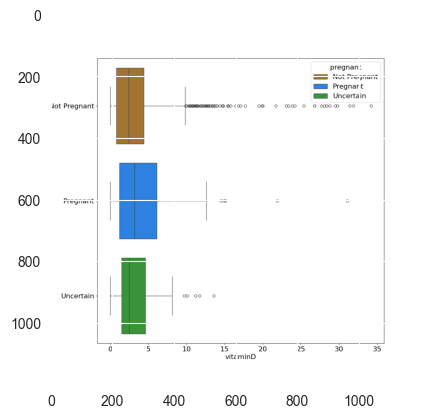

In [5]:
def read_img_show(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()

def plot_multiple_boxplots():
    """
    This is an example of code to run the multiple boxplot automation script. We do not recommend running it in a jupyter server as it is computationally intensive. The output of the script can be found at ../Data/Final/Plots/Boxplots/*. An example of the first graph generated from the below code will be shown.
    """
    df = get_combined_df()

    xs = ['vitaminD', 'vitaminB12']
    ys = ['pregnant', 'race']

    return read_img_show('../Data/Final/Plots/Boxplots/pregnant/pregnant_vitaminD.png')
    # below will run automation script
    AutoEDAVisualizatons.boxplots(df, xs, ys)

plot_multiple_boxplots()

### Deficiency Analysis - By Nutrient


From there, we decided to do look at the number of deficiencies among different demographic subgroups and different nutrients. To do this analysis, we scraped the daily recommended intake values from the [fda's website](https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels) (get_fda_recommnd_df()). Using those values we made a boolean dataframe where 0's represent individuals who were equal to or below this value and 1's represent individuals who were above this value (get_deficiences_df()). From there we calculated the proportion of individuals who were deficient for each nutrient variable (proportion_deficient_df()), and plotted the results (plot_percent_deficient()).

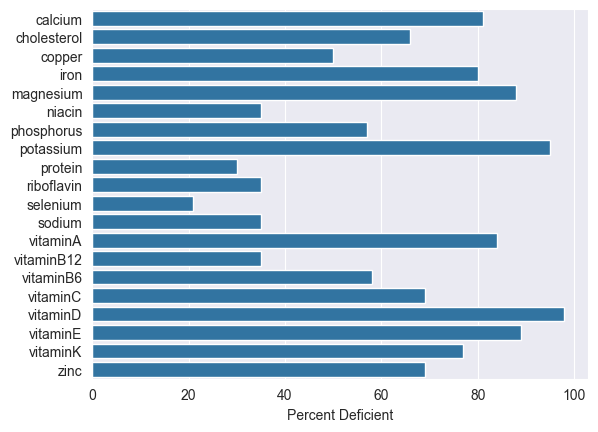

In [6]:
def get_fda_recommend_df():
    """
    Gets the FDA's recommendation of daily nutrition intake values
    src:
        'https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels'
    :return: (pd.DataFrame)
    """
    df_fda = pd.read_html('https://www.fda.gov/food/nutrition-facts-label/daily-value-nutrition-and-supplement-facts-labels')[0]
    df_fda['Current Daily Value'] = df_fda['Current Daily Value'].str.extract('(\d+(\.\d+)?)')[0].astype(np.float32)
    return df_fda

def get_deficiencies_df():
    """

    :param df_nhanes:
    :param df_fda:
    :param dict_map: maps nhanes_col_name to fda_col_name
    :return:
    """
    df_nhanes = get_combined_df()
    df_fda = get_fda_recommend_df()

    dict_map = NHANESDataFrame.get_nhanes_to_fda_rec_dict()
    dict_map_inv = {v: k for k, v in dict_map.items()}

    recs = df_fda.set_index('Nutrient').to_dict()['Current Daily Value']
    recs = {dict_map_inv[k]: v for k, v in recs.items() if k in dict_map_inv}

    recs = pd.Series(recs)
    df = df_nhanes[list(dict_map.keys())]
    df, recs = df.align(recs, axis=1)

    df = df > recs
    return df.astype(int)

def proportion_deficient_df():
    df = get_deficiencies_df()
    out_dict = {}
    for col in df.columns:
        counts = df.value_counts(col, True).to_dict()
        out_dict[col] = counts

    df = pd.DataFrame(
        out_dict
    ).transpose(

    ).reset_index(
        names='nutrient'
    ).rename(
        columns={1: "Adequate", 0: "Deficient"}
    )
    return df

def plot_percent_deficient():
    df = proportion_deficient_df()
    df.Deficient = (df.Deficient * 100).astype(int)
    sns.barplot(df, x='Deficient', y='nutrient')
    plt.ylabel(None)
    plt.xlabel("Percent Deficient")
    plt.show()

plot_percent_deficient()

### Deficiency Analysis - By Sub-Demographic

We were interested in exploring the deficiencies among different subgroups within a demographic variable (for the demographic variable pregnant, the subgroups are pregnant, not pregnant, or unsure). To do this we created a function to compare the mean of a demographic subgroup versus the rest of that group for a given nutrient using a two-sided t-test. (e.g. does the mean for calcium intake among pregnant women vary significantly compared to non-pregnant and unsure women). From those results, we were summed up the number of deficiencies among different subgroups and plotted the results. A light-weight example of the output and graph is provided below.

['USA'] are significantly different than rest of country_born in vitaminB6 intake
['Not Pregnant'] are significantly different than rest of pregnant in iron intake
['USA'] are significantly different than rest of country_born in vitaminC intake
['Some College', 'High School'] are significantly different than rest of education in vitaminD intake
['Female'] are significantly different than rest of gender in iron intake


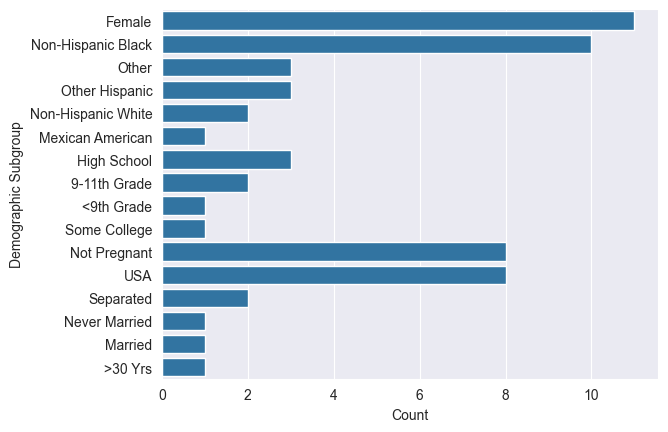

In [7]:
def population_difference_identifier(df: pd.DataFrame, demographic: str, nutrient: str) -> tuple:
    """
    This function filters the dataframe by each distinct value in demographic column,
    and checks if there is a statistically significant difference in that subgroup
    compared to the rest of the population using a t-test p-value (<0.05)
    :param df: NHANES combined DF
    :param demographic: demographic column name
    :param nutrient: nutrient column name
    :return: (tuple)
        returns (nutrient, demographic, sub_group) for those subgroups that are significant
    """
    out = []
    #get the unique values from the specified demographic
    sub_groups = pd.unique(df[demographic])
    for sub_group in sub_groups:
        sub_group_data = df[df[demographic]==sub_group][nutrient].values
        everyone_else = df[df[demographic]!=sub_group][nutrient].values
        chival, pval = ttest_ind(everyone_else, sub_group_data)
        if pval < 0.05 and sub_group_data.mean() < everyone_else.mean():
            out.append(sub_group)

    return out

def get_significant_subgroups():
    """
    Runs an example of the EDA function that allows us to systematically look for subgroups that
    are statistically different than the rest of the population
    :return:
    """
    demographics = list(NHANESDataFrame.get_sparse_to_cat_dict().keys())
    nutrients = [
        'protein', 'calcium', 'phosphorus',
        'magnesium', 'vitaminA', 'vitaminB6', 'vitaminB12',
        'vitaminC', 'vitaminD', 'vitaminK', 'iron', 'sodium'
    ]

    df = get_combined_df()
    df = NHANESDataFrame.sparse_col_to_str(df)

    name_tup = namedtuple("Row", "demographic nutrient sig_subgroups")
    out = []
    for demographic in demographics:
        for nutrient in nutrients:
            sig_subgroups = population_difference_identifier(df, demographic, nutrient)
            if len(sig_subgroups) > 0:
                out.append(name_tup(demographic, nutrient, sig_subgroups))

    for i in np.random.randint(0, len(out), 5):
        tup = out[i]
        print(f'{tup.sig_subgroups} are significantly different than rest of {tup.demographic} in {tup.nutrient} intake')
    return out

counter = Counter()
for sig_subgroup in get_significant_subgroups():
    subgroup = sig_subgroup[2]
    counter.update(subgroup)

df = pd.Series(
    counter
).reset_index(
    name="Count"
).rename(
    columns={'index': 'Demographic Subgroup'}
)

sns.barplot(df, x="Count", y="Demographic Subgroup")
plt.show()

### Consolidation of Information and Further Analysis

Using the previous graphs as inspiration, we decided on a number of variables to investigate further. We created a function to plot a ridgeplot. The ridgeplot function can be found in [visualizations.Visualizations.ridgeplot](x). Below we have written a function to create a ridgeplot with those variables of interest.

<Figure size 1200x1200 with 0 Axes>

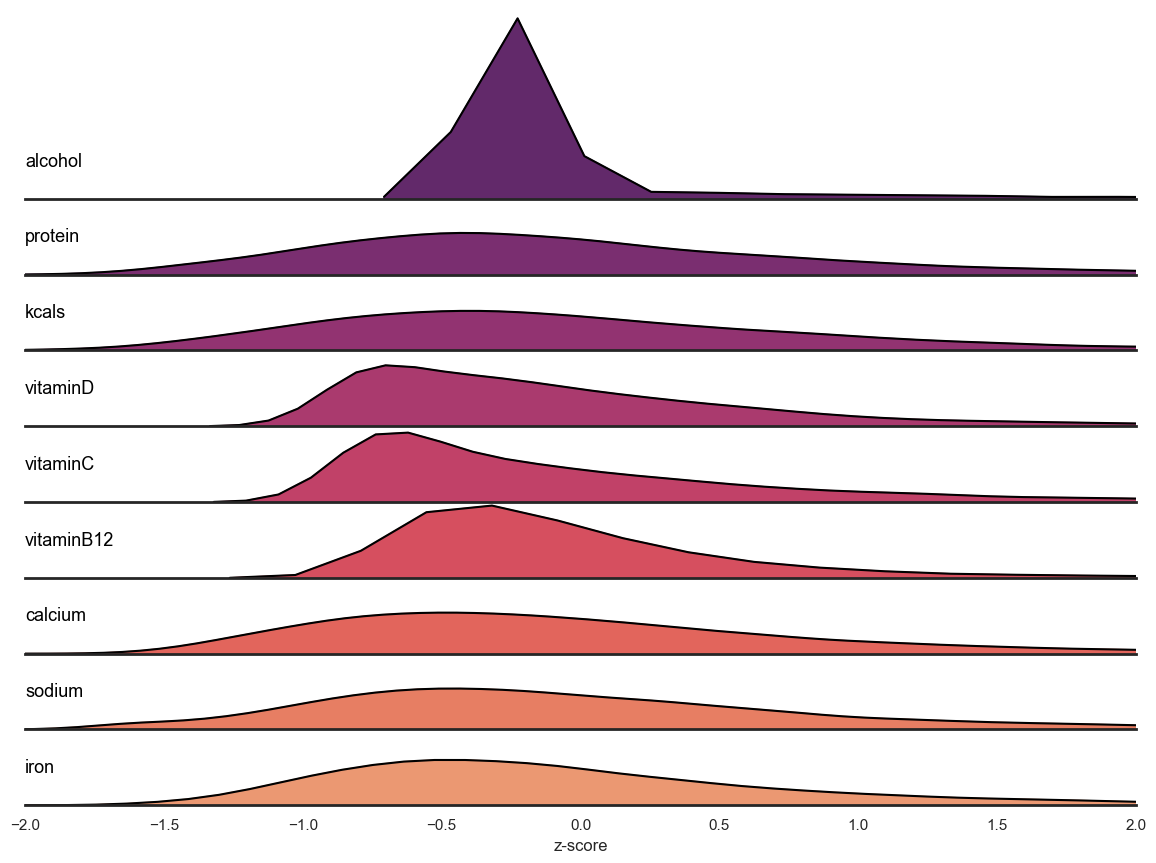

In [8]:
def plot_distributions_ridgeplot():
    vars = ['alcohol', "protein", "kcals", 'vitaminD', 'vitaminC', 'vitaminB12', 'calcium', 'sodium', 'iron']
    df = get_combined_df()
    df = df[vars]
    xlim = (-2, 2)
    Visualizations.ridgeplot(df, xlim=xlim, sorder=vars)

plot_distributions_ridgeplot()

### Distributions of interest
#### Iron-Sodium
The distributions we found to be most interesting were the iron, sodium, and calcium distributions. All three had very broad distributions meaning there were many people deficient and over indulgent in the intake of those nutrients. Furthermore, iron deficiency is fairly common and can cause iron deficiency anemia which is characterized by tiredness, shortness of breath, and/or chest pain. For many people with iron deficiency anemia, simply consuming more foods with can help curb this disease. [NIH](https://www.nhlbi.nih.gov/health/anemia/iron-deficiency-anemia) However, some of the most popular foods that are rich in iron are also rich in sodium. Red meat: beef, lamb and pork as well as fortified breads, snacks, and cereals are all high in iron but also high in sodium. Therefore, we were interested in the relationship between iron and sodium intake and whether there seemed to be a correlation.

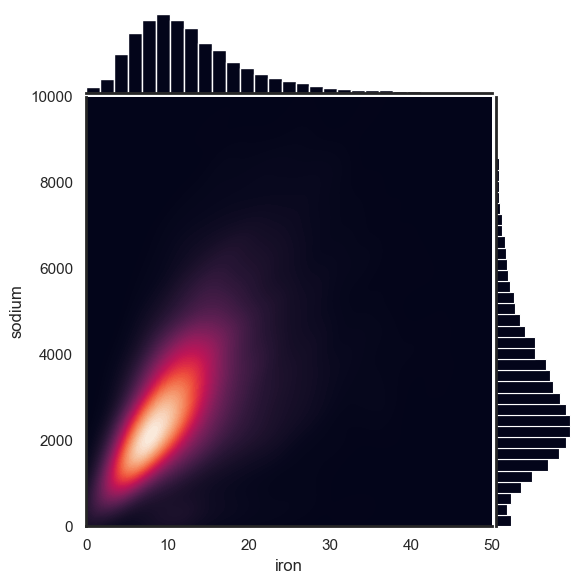

'The correlation between iron and sodium is  0.5498'

In [13]:
def plot_iron_sodium_joint_grid():
    """ plots a iron sodium joint grid. Full code to plot 2d kde joint gride can be found at visualizations.Visualizations.joint_grid_2dkde_marg_hist """
    df = get_combined_df()
    x = 'iron'
    y = 'sodium'
    xlim = (0, 50)
    ylim = (0, 10000)
    Visualizations().joint_grid_2dkde_marg_hist(df, x, y, xlim, ylim)

plot_iron_sodium_joint_grid()

df = get_combined_df()
f'The correlation between iron and sodium is {df.iron.corr(df.sodium): 0.4f}'

#### Male/Females Calcium

The other distribution of interest was calcium, particularly the differences in calcium intake between males and females. Our bodies have two particular cells called osteoblasts and osteoclasts. Osteoblasts are responsible for building up bone and osteoclasts are responsible for breaking down done. Children have many more osteoblasts than osteoclasts to support growth, as we reach full size, the numbers of both cells equalize, but as we enter middle-older age, the number of osteoclasts outpaces the number of osteoblasts and our bodies start going through process known as resorption. During this stage our bones can become brittle as calcium is reabsorbed back into the body. This process makes conditions such as osteoporosis more common and is more prevalent in females than males. [Samwald et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7415937/#:~:text=Osteoporosis%20is%20a%20metabolic%20bone,increasing%20the%20risk%20of%20fractures.)

In [10]:
def plot_calcium_male_female_violin():
    """
    The code will plot a split violin plot of male vs female calcium distributions.
    The full code to create split violin plots can be found at
    visualizations.Visualizations.violin_plot_calcium
    """
    df = get_combined_df()
    df = NHANESDataFrame.sparse_col_to_str(df, 'gender')
    df['age_yrs_binned'] = pd.cut(df['age_yrs'], [0, 20, 50, 79.9, 150], labels=["0-20", "20-50", "50-80", "80+"])

    rename_cols = {'gender': "Sex", "age_yrs_binned": "Age", "calcium": "Calcium (mg)"}
    df = df.rename(columns=rename_cols)

    x = 'Age'
    y = 'Calcium (mg)'
    hue = 'Sex'
    ylim = (-100, 3500)

    Visualizations.violin_plot_calcium(df, x, y, hue, ylim, "/Users/joshfisher/PycharmProjects/MADS_Milestone1/Data/Final/Plots/Writeup/violins.png")


plot_calcium_male_female_violin()

### Male vs Female Calcium intake

The next step we took was to explore whether the differences in mean between the two groups are significantly significant. To do this, we ran a two-sided t-test.

alpha = 0.01
Null Hypothesis: Two samples have identical means
Alternative Hypothesis: Two samples' means differ

In [11]:
df = get_combined_df()
male_calcium = df.loc[df.gender == 1].calcium
female_calcium = df.loc[df.gender == 2].calcium

res = ttest_ind(male_calcium, female_calcium)
display(f'pvalue: {res.pvalue: 0.3E}')

'pvalue:  1.906E-74'

The p-value is less than alpha and therefore, we reject the null hypothesis in favor of the alternative hypothesis, that the true means of the subgroups differ.

Obviously, males eat more than females (on average) and therefore would consume more kcals and proportionally intake more calcium (acting as an extraneous variable). When we standardize calcium by an individual's kcal consumption, we do find that the statistical signficance goes away. However, modern guidelines suggest that - because of the higher rates of resorption in women - males and females intake the same amount of calcium despite size difference. Therefore, it is safe to not standardize by kcals and compare the raw means which remain statistically significant.